In [1]:
from keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

import keras.backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In this script, we will focus on generating the content

In [2]:
def VGG16_AvgPool(shape):
    # we want to account for features across the entrie image
    # so we get rid of the maxpool which throws away information
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)
    
    new_model = Sequential()
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            # replace it with average pooling
            new_model.add(AveragePooling2D())
        else:
            new_model.add(layer)
    return new_model

In [15]:
def VGG16_AvgPool_Cutoff(shape, num_convs):
    # there are 13 convs in total
    # we can pick any of then as the "output" of out content model
    if num_convs < 1 or num_convs > 13:
        print("num_convs must be in the range [1,13]")
        return None
    
    model = VGG16_AvgPool(shape)
    new_model = Sequential()
    n = 0
    for layer in model.layers:
        if layer.__class__ == Conv2D:
            n += 1
        new_model.add(layer)
        if n >= num_convs:
            break
    return new_model

In [16]:
def unpreprocess(img):
    # un-preprocess image from keras vgg which subtract mean
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

In [17]:
def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

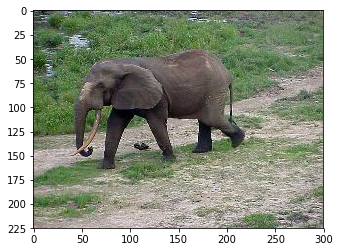

In [18]:
path = './data/content/elephant.jpg'
img = image.load_img(path)
plt.imshow(img)

In [19]:
# convert image to array and preprocess for vgg
x = image.img_to_array(img)
print(x.shape)
x = np.expand_dims(x, axis=0)  # keras expect to be batch shape
print(x.shape)
x = preprocess_input(x)
print(x.shape)

(225, 300, 3)
(1, 225, 300, 3)
(1, 225, 300, 3)


In [20]:
# we will use this throughout the rest of the script
batch_shape = x.shape
shape = x.shape[1:]

In [57]:
# make a content model and predict
content_model = VGG16_AvgPool_Cutoff(shape, 11)
target = K.variable(content_model.predict(x))

ValueError: Input 0 is incompatible with layer block1_conv1: expected ndim=4, found ndim=1

In [ ]:
# try to match the image

# define loss in keras (square error)
loss = K.mean(K.square(target - content_model.output))
# gradients which are needed by the optimizer
grads = K.gradients(loss, content_model.input)

get_loss_and_grads = K.function(
    inputs=[content_model.input],
    outputs=[loss] + grads
)

Scipy's minimizer allows us to pass back function value f(x) and it's gradient f'(x) simultaneously, rahter than using the fprime arg

We cannot use get_loss_and_grads() directly 

input to minimizer function must be a 1-D array

input to get_loss_and_grads must be batch_of_images

gradient must also be a 1-D array and bost loss and gradient must be np.float64, will get an error otherwise

In [ ]:
def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

In [58]:
losses = []
x = np.random.randn(np.prod(batch_shape))

iter= 0 , loss= 21.432329177856445
iter= 1 , loss= 8.240302085876465
iter= 2 , loss= 4.887292861938477
iter= 3 , loss= 3.5711488723754883
iter= 4 , loss= 2.79488205909729
iter= 5 , loss= 2.324859619140625
iter= 6 , loss= 1.975894808769226
iter= 7 , loss= 1.7343013286590576
iter= 8 , loss= 1.556205153465271
iter= 9 , loss= 1.4204280376434326


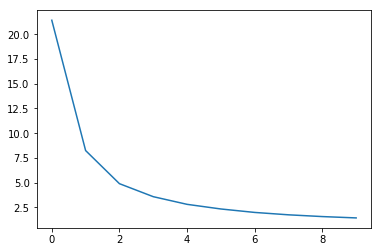

In [59]:
for i in range(10):
    x, l, _ = fmin_l_bfgs_b(
        func=get_loss_and_grads_wrapper,
        x0=x,
        maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=", i, ',', 'loss=', l)
    losses.append(l)
    
plt.plot(losses)

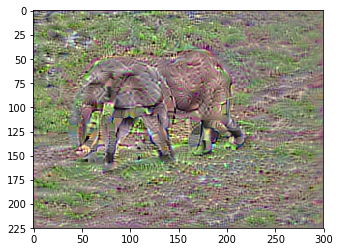

In [60]:
new_img = x.reshape(*batch_shape)
final_img = unpreprocess(new_img)

plt.imshow(scale_img(final_img[0]))
